<a href="https://colab.research.google.com/github/sahil3155/machinelearning/blob/main/Text_classification_Tensorflow_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [20]:
df= pd.read_csv("wine-reviews.csv", usecols=['country','description','points','price','variety','winery'])

In [21]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


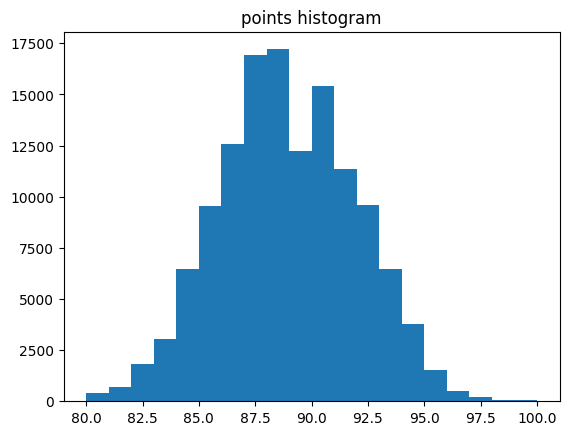

In [22]:
plt.hist(df['points'],bins=20)
plt.title('points histogram')
plt.show()

In [25]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [26]:
df.head()

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0


In [27]:
train,val,test= np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [28]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [29]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

Embedding


In [30]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [31]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.3489163 , -0.3709588 , -0.12154965, ...,  0.07218796,
        -0.02812198,  0.19728227],
       [ 0.33225155, -0.14807616, -0.09394569, ..., -0.14534283,
        -0.25340244,  0.17740577],
       [ 0.30651274, -0.2503155 ,  0.29101953, ..., -0.10179231,
        -0.16789082,  0.04056133],
       ...,
       [ 0.4250986 , -0.12129316, -0.03994763, ...,  0.08229043,
        -0.13522802,  0.01002294],
       [ 0.40097144,  0.06181733,  0.22906797, ..., -0.133888  ,
        -0.24474819,  0.13713264],
       [ 0.06998552, -0.03171869,  0.14600524, ..., -0.0949235 ,
        -0.23344152,  0.03076854]], dtype=float32)>

In [32]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [35]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [37]:
model.evaluate(train_data)

102/102 [==============================] - 4s 19ms/step - loss: 0.7236 - accuracy: 0.3905


[0.7235904335975647, 0.39050358533859253]

In [38]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 25ms/step - loss: 0.7226 - accuracy: 0.3921


[0.722572386264801, 0.39209046959877014]

In [41]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 170s 2s/step - loss: 0.5458 - accuracy: 0.7237 - val_loss: 0.4299 - val_accuracy: 0.8007
Epoch 2/5
102/102 [==============================] - 197s 2s/step - loss: 0.4297 - accuracy: 0.8129 - val_loss: 0.3898 - val_accuracy: 0.8195
Epoch 3/5
102/102 [==============================] - 194s 2s/step - loss: 0.3859 - accuracy: 0.8397 - val_loss: 0.3744 - val_accuracy: 0.8271
Epoch 4/5
102/102 [==============================] - 193s 2s/step - loss: 0.3560 - accuracy: 0.8525 - val_loss: 0.3720 - val_accuracy: 0.8283
Epoch 5/5
102/102 [==============================] - 190s 2s/step - loss: 0.3330 - accuracy: 0.8623 - val_loss: 0.3711 - val_accuracy: 0.8299


In [42]:
model.evaluate(test_data)

13/13 [==============================] - 5s 412ms/step - loss: 0.3746 - accuracy: 0.8271


[0.37464261054992676, 0.8271272778511047]

LSTM

In [44]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_data.map(lambda text, label: text))

In [45]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U15')

In [46]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [47]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [48]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 3s 229ms/step - loss: 0.6935 - accuracy: 0.4656


[0.693482518196106, 0.46556898951530457]

In [49]:


history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 78s 434ms/step - loss: 0.5493 - accuracy: 0.7099 - val_loss: 0.3921 - val_accuracy: 0.8194
Epoch 2/5
102/102 [==============================] - 45s 435ms/step - loss: 0.3871 - accuracy: 0.8253 - val_loss: 0.3760 - val_accuracy: 0.8233
Epoch 3/5
102/102 [==============================] - 43s 420ms/step - loss: 0.3714 - accuracy: 0.8326 - val_loss: 0.3696 - val_accuracy: 0.8254
Epoch 4/5
102/102 [==============================] - 39s 379ms/step - loss: 0.3658 - accuracy: 0.8352 - val_loss: 0.3650 - val_accuracy: 0.8305
Epoch 5/5
102/102 [==============================] - 41s 402ms/step - loss: 0.3636 - accuracy: 0.8351 - val_loss: 0.3713 - val_accuracy: 0.8260


In [50]:
model.evaluate(test_data)

13/13 [==============================] - 3s 273ms/step - loss: 0.3731 - accuracy: 0.8254


[0.3730681240558624, 0.825434684753418]